<a href="https://colab.research.google.com/github/Tongfei12/PHAS0077-Scientific-Computing-Individual-Research-Project/blob/main/peptide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the data and import the necessary packages

In [ ]:
import h5py
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import time 

drive.mount('/content/drive')
f = h5py.File('/content/drive/MyDrive/fs_peptide.h5', 'r')
analysis = np.array(f['analysis']['full_cmaps'])
unique_map = np.unique(analysis, axis=0)

Mounted at /content/drive


# **The CVAE model of peptide data set**

(16, 2)
Tensor("sequential_1/conv2d_transpose_2/BiasAdd:0", shape=(16, 21, 21, 1), dtype=float32)


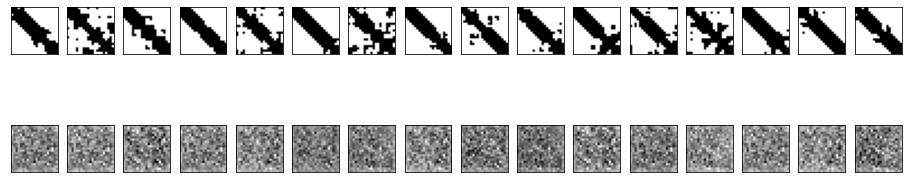

(100, 2)
Tensor("sequential_1/conv2d_transpose_2/BiasAdd:0", shape=(100, 21, 21, 1), dtype=float32)
Epoch: 10, Test set ELBO: -78.17867279052734, time elapse for current epoch 358.2160212993622


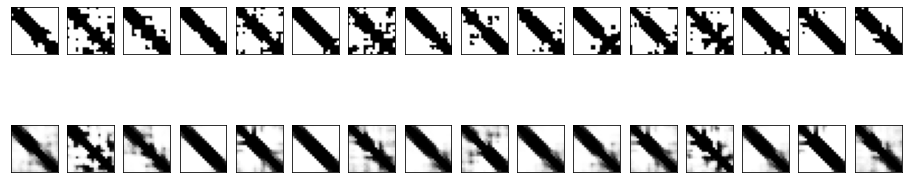

Epoch: 20, Test set ELBO: -74.80343627929688, time elapse for current epoch 353.9733850955963


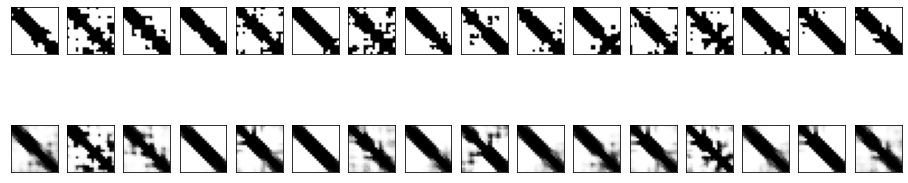

Epoch: 30, Test set ELBO: -72.83367919921875, time elapse for current epoch 353.9131796360016


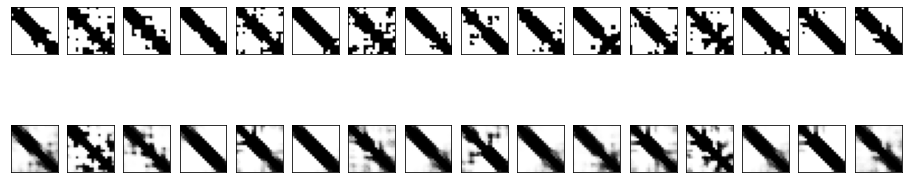

Epoch: 40, Test set ELBO: -71.38849639892578, time elapse for current epoch 353.9226641654968


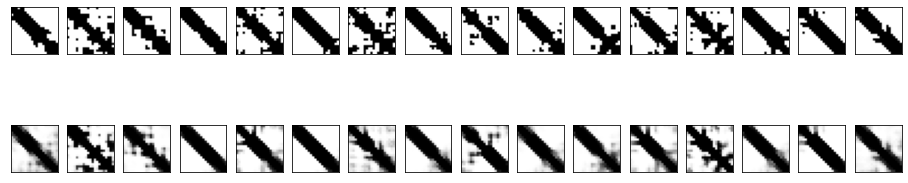

Epoch: 50, Test set ELBO: -70.61888122558594, time elapse for current epoch 364.9374644756317


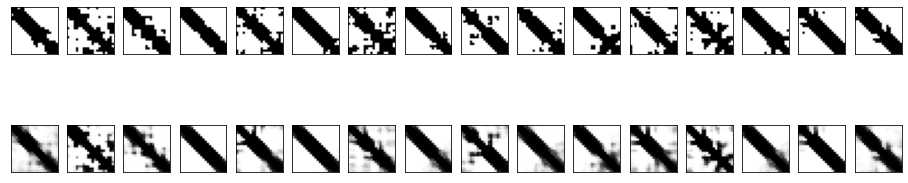

Epoch: 60, Test set ELBO: -69.93922424316406, time elapse for current epoch 363.5712082386017


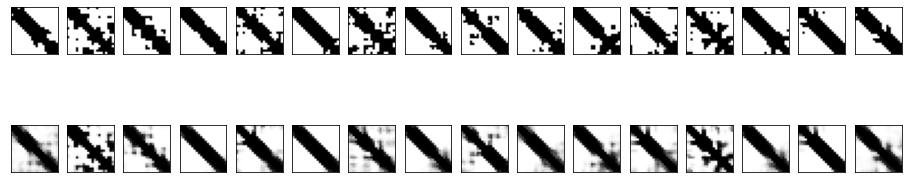

In [ ]:
#reshape the data set
train, test = train_test_split(analysis, test_size = 0.3)
train = train.reshape(train.shape[0], 21, 21, 1).astype('float32')
test = test.reshape(test.shape[0], 21, 21, 1).astype('float32')
BATCH_SIZE = 100

train_dataset = tf.data.Dataset.from_tensor_slices(train).shuffle(train.shape[0]).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test).shuffle(test.shape[0]).batch(BATCH_SIZE)

#create the model
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(21,21,1)),
          tf.keras.layers.Conv2D(
              filters=18, kernel_size=3, strides=3, activation='relu'),
          tf.keras.layers.Conv2D(
              filters=36, kernel_size=3, strides=3, activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=21*21*18, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(21, 21, 18)),
          tf.keras.layers.Conv2DTranspose(
              filters=36,
              kernel_size=3,
              strides=1,
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=18,
              kernel_size=3,
              strides=1,
              padding="SAME",
              activation='relu'),
          # No activation
           tf.keras.layers.Conv2DTranspose(
               filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    print(z.shape)
    logits = self.generative_net(z)
    print(logits)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits


optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

#the loss function
@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
    
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  
epochs = 101
latent_dim = 2
num_examples_to_generate = 16

# Keep the random vector constant for generation (prediction) to make it easier to see improvements.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)


def generate_and_save_images(model, epoch, test_sample):
  # Reconstruction
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(20, 4))
    for i in range(predictions.shape[0]):
            # display original
        ax = plt.subplot(2, 20, i + 1)
        test_sample = np.array(test_sample)
        plt.imshow(test_sample[i].reshape(21,21))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

            # display reconstruction
        ax = plt.subplot(2, 20, i + 1 + 20)
        plt.imshow(predictions[i,:,:,0])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

generate_and_save_images(model, 0, test_sample)
losses = []
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 10 == 0:
    loss = tf.keras.metrics.Mean()
    
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    losses.append(loss.result()) 
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, test_sample)
    
#plot the loss function image
t = np.arange(0,epoch,1)
plt.plot(t, losses)

# **The AAE model of peptide data set**

In [ ]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
import numpy as np
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers.advanced_activations import LeakyReLU

# -------------------------------------------------------------------------------------------------------------
# Set random seed
tf.random.set_seed(50)
np.random.seed(50)

# -------------------------------------------------------------------------------------------------------------
# Loading data
train, test = train_test_split(unique_map, test_size = 0.3)
train = train.reshape((-1, 21 * 21)).astype('float32')
test = test.reshape((-1, 21 * 21)).astype('float32')

# -------------------------------------------------------------------------------------------------------------
# Create the dataset iterator
batch_size = 256
train_buf = train.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices(train)
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

# -------------------------------------------------------------------------------------------------------------
# Create models
img_shape = 441
latent_dim = 2


def build_encoder():
    # Encoder

    input = Input(shape=(img_shape,))

    h = Dense(512)(input)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    encoded = Dense(latent_dim)(h)
    model = tf.keras.Model(inputs=input, outputs=encoded)
    return model
  

def build_decoder():

    encoded = Input(shape=(latent_dim,))
    h = Dense(512)(encoded)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dropout(0.5)(h)
    reconstruction = Dense(img_shape, activation='sigmoid')(h)
    model = tf.keras.Model(inputs=encoded, outputs=reconstruction)
    return model


def build_discriminator():
    model = tf.keras.Sequential()

    model.add(Dense(512, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()

    encoded_repr = Input(shape=(latent_dim,))
    validity = model(encoded_repr)

    return tf.keras.Model(encoded_repr, validity)

encoder = build_encoder()
decoder = build_decoder()
discriminator = build_discriminator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               1536      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 133,121
Trainable params: 133,121
Non-trainable params: 0
_________________________________________________________________


Define the loss functions and the learning rate

In [ ]:
# -------------------------------------------------------------------------------------------------------------
# Define loss functions
ae_loss_weight = 1.
gen_loss_weight = 1.
dc_loss_weight = 1.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse = tf.keras.losses.MeanSquaredError()
accuracy = tf.keras.metrics.BinaryAccuracy()


def autoencoder_loss(input, reconstruction, loss_weight):
    return loss_weight * mse(input, reconstruction)


def discriminator_loss(real_output, fake_output, loss_weight):
    loss_real = cross_entropy(tf.ones_like(real_output), real_output)
    loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return loss_weight * (loss_fake + loss_real)


def generator_loss(fake_output, loss_weight):
    return loss_weight * cross_entropy(tf.ones_like(fake_output), fake_output)

# -------------------------------------------------------------------------------------------------------------
# Define cyclic learning rate
base_lr = 0.00025
max_lr = 0.0025

n_samples = train.shape[0]
step_size = 2 * np.ceil(n_samples / batch_size)
global_step = 0

# -------------------------------------------------------------------------------------------------------------
# Define optimizers
ae_optimizer = tf.keras.optimizers.Adam(lr=base_lr)
dc_optimizer = tf.keras.optimizers.Adam(lr=base_lr)
gen_optimizer = tf.keras.optimizers.Adam(lr=base_lr)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


The training step

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


   0: TIME: 59.44 ETA: 5943.70 AE_LOSS: 0.0880 DC_LOSS: 1.3404 DC_ACC: 62.2631 GEN_LOSS: 1.3974


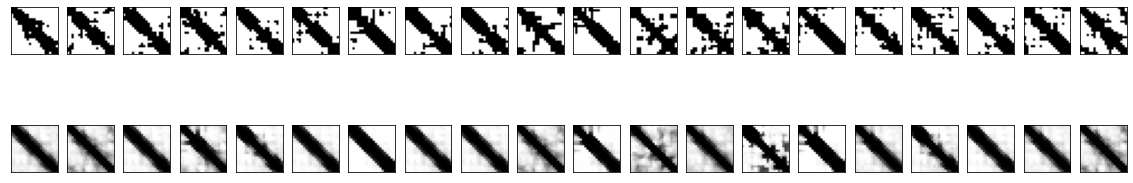

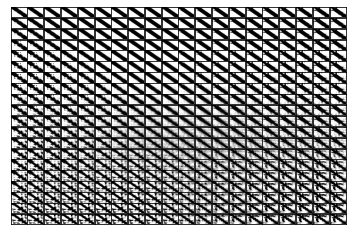

   1: TIME: 48.77 ETA: 4828.40 AE_LOSS: 0.0728 DC_LOSS: 1.3133 DC_ACC: 58.9018 GEN_LOSS: 0.7969
   2: TIME: 57.88 ETA: 5672.00 AE_LOSS: 0.0701 DC_LOSS: 1.3296 DC_ACC: 59.1222 GEN_LOSS: 0.7815
   3: TIME: 49.13 ETA: 4765.57 AE_LOSS: 0.0687 DC_LOSS: 1.3444 DC_ACC: 58.8722 GEN_LOSS: 0.7557
   4: TIME: 44.67 ETA: 4288.58 AE_LOSS: 0.0824 DC_LOSS: 1.4139 DC_ACC: 58.3976 GEN_LOSS: 0.8055
   5: TIME: 82.07 ETA: 7796.53 AE_LOSS: 0.0923 DC_LOSS: 1.4037 DC_ACC: 57.6348 GEN_LOSS: 0.9085
   6: TIME: 82.08 ETA: 7715.55 AE_LOSS: 0.0778 DC_LOSS: 1.3581 DC_ACC: 57.4959 GEN_LOSS: 0.7822
   7: TIME: 82.14 ETA: 7638.59 AE_LOSS: 0.0706 DC_LOSS: 1.3568 DC_ACC: 57.5616 GEN_LOSS: 0.7311
   8: TIME: 82.07 ETA: 7550.29 AE_LOSS: 0.0706 DC_LOSS: 1.3530 DC_ACC: 57.4223 GEN_LOSS: 0.7408
   9: TIME: 82.09 ETA: 7469.94 AE_LOSS: 0.1052 DC_LOSS: 1.5762 DC_ACC: 57.3848 GEN_LOSS: 3.8419
  10: TIME: 82.07 ETA: 7386.35 AE_LOSS: 0.0776 DC_LOSS: 1.3238 DC_ACC: 57.5279 GEN_LOSS: 0.7760


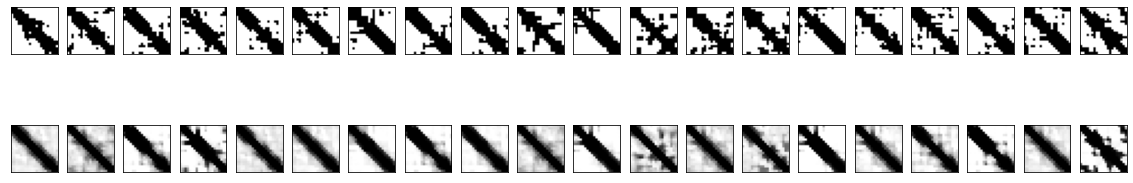

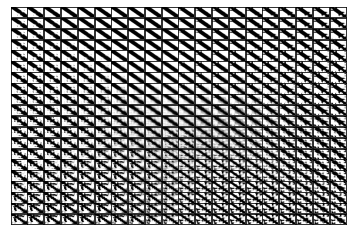

In [ ]:
# -------------------------------------------------------------------------------------------------------------
# Training function
@tf.function
def train_step(batch_x):
    # -------------------------------------------------------------------------------------------------------------
    # Autoencoder
    with tf.GradientTape() as ae_tape:
        encoder_output = encoder(batch_x, training=True)
        decoder_output = decoder(encoder_output, training=True)

        # Autoencoder loss
        ae_loss = autoencoder_loss(batch_x, decoder_output, ae_loss_weight)

    ae_grads = ae_tape.gradient(ae_loss, encoder.trainable_variables + decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(ae_grads, encoder.trainable_variables + decoder.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Discriminator
    with tf.GradientTape() as dc_tape:
        real_distribution = tf.random.normal([batch_x.shape[0], latent_dim], mean=0.0, stddev=1.0)
        encoder_output = encoder(batch_x, training=True)

        dc_real = discriminator(real_distribution, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Discriminator Loss
        dc_loss = discriminator_loss(dc_real, dc_fake, dc_loss_weight)

        # Discriminator Acc
        dc_acc = accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                          tf.concat([dc_real, dc_fake], axis=0))

    dc_grads = dc_tape.gradient(dc_loss, discriminator.trainable_variables)
    dc_optimizer.apply_gradients(zip(dc_grads, discriminator.trainable_variables))

    # -------------------------------------------------------------------------------------------------------------
    # Generator (Encoder)
    with tf.GradientTape() as gen_tape:
        encoder_output = encoder(batch_x, training=True)
        dc_fake = discriminator(encoder_output, training=True)

        # Generator loss
        gen_loss = generator_loss(dc_fake, gen_loss_weight)

    gen_grads = gen_tape.gradient(gen_loss, encoder.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, encoder.trainable_variables))

    return ae_loss, dc_loss, dc_acc, gen_loss


# -------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 100
dcloss = []
genloss = []
aeloss = []
for epoch in range(n_epochs):
    start = time.time()
    #calculate the loss
    epoch_ae_loss_avg = tf.metrics.Mean()
    epoch_dc_loss_avg = tf.metrics.Mean()
    epoch_dc_acc_avg = tf.metrics.Mean()
    epoch_gen_loss_avg = tf.metrics.Mean()


    for batch, (batch_x) in enumerate(train_dataset):
        # -------------------------------------------------------------------------------------------------------------
        # calculate cyclic learning rate
        global_step = global_step + 1
        cycle = np.floor(1 + global_step / (2 * step_size))
        x_lr = np.abs(global_step / step_size - 2 * cycle + 1)
        clr = base_lr + (max_lr - base_lr) * max(0, 1 - x_lr)
        ae_optimizer.lr = clr
        dc_optimizer.lr = clr
        gen_optimizer.lr = clr

        ae_loss, dc_loss, dc_acc, gen_loss = train_step(batch_x)

        epoch_ae_loss_avg(ae_loss)
        epoch_dc_loss_avg(dc_loss)
        epoch_dc_acc_avg(dc_acc)
        epoch_gen_loss_avg(gen_loss)
    
    #add the loss result to the list
    dcloss.append(epoch_dc_loss_avg.result())
    genloss.append(epoch_gen_loss_avg.result())
    aeloss.append(epoch_ae_loss_avg.result())
    epoch_time = time.time() - start
    print('{:4d}: TIME: {:.2f} ETA: {:.2f} AE_LOSS: {:.4f} DC_LOSS: {:.4f} DC_ACC: {:.4f} GEN_LOSS: {:.4f}' \
          .format(epoch, epoch_time,
                  epoch_time * (n_epochs - epoch),
                  epoch_ae_loss_avg.result(),
                  epoch_dc_loss_avg.result(),
                  100*epoch_dc_acc_avg.result(),
                  epoch_gen_loss_avg.result()))
    
    # -------------------------------------------------------------------------------------------------------------
    if epoch % 10 == 0:

        # Reconstruction
        n_digits = 20  # how many digits we will display
        x_test_decoded = decoder(encoder(test[:n_digits], training=False), training=False)
        x_test_decoded = np.reshape(x_test_decoded, [-1, 21, 21]) * 255
        fig = plt.figure(figsize=(20, 4))
        for i in range(n_digits):
            # display original
            ax = plt.subplot(2, n_digits, i + 1)
            plt.imshow(test[i].reshape(21, 21))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n_digits, i + 1 + n_digits)
            plt.imshow(x_test_decoded[i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
        plt.show()

        # Sampling
        x_points = np.linspace(-3, 3, 20).astype(np.float32)
        y_points = np.linspace(-3, 3, 20).astype(np.float32)

        nx, ny = len(x_points), len(y_points)
        plt.subplot()
        gs = gridspec.GridSpec(nx, ny, hspace=0.05, wspace=0.05)

        for i, g in enumerate(gs):
            z = np.concatenate(([x_points[int(i / ny)]], [y_points[int(i % nx)]]))
            z = np.reshape(z, (1, 2))
            x = decoder(z, training=False).numpy()
            ax = plt.subplot(g)
            img = np.array(x.tolist()).reshape(21, 21)
            ax.imshow(img, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('auto')
        plt.show()
        
#plot the loss function images
t = np.arange(0, n_epochs, 1)
plt.title("Discriminator loss and Generator loss")
plt.plot(t, dcloss)
plt.plot(t, genloss)  
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['Discriminator Loss', 'Generator Loss'], loc = 'upper left')
plt.show()

plt.title("Autoencoder loss")
plt.plot(t, aeloss)
plt.xlabel("epochs")
plt.ylabel("autoencoder loss")
plt.show()